<a href="https://colab.research.google.com/github/LuvTheCoder/StockPrediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
ticker = 'AAPL'  # Can change this to 'TSLA', 'MSFT', 'GOOGL', etc.
df = yf.download(ticker, start='2010-01-01', end='2025-07-11')

df.head()

/tmp/ipython-input-3-2157562259.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2010-01-01', end='2025-07-11')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431897,6.446623,6.382908,6.414465,493729600
2010-01-05,6.443015,6.479381,6.409054,6.449627,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328811,6.371488,6.282828,6.363974,477131200
2010-01-08,6.370886,6.371488,6.283129,6.320395,447610800


In [4]:
data = df[['Close']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences of 60 days to predict the next day
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshaping input for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential()

# Bidirectional LSTM to learn in both forward and backward directions
model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X.shape[1], 1)))
model.add(Dropout(0.3))

model.add(LSTM(units=120, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 60, 200)        │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 120)        │       154,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 100)        │        88,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 80)             │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,249 (1.48 MB)

 Trainable params: 387,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X, y, epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0243
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0036
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0054
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0025
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0027
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0023
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0023
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0021
Epoch 9/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0020
Epoch 10/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0020
Epoch 11/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0019
Epoch 12/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0019
Epoch 13/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0018
Epoch 14/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0018
Epoch 15/100
121/121 ━━━━━━━━

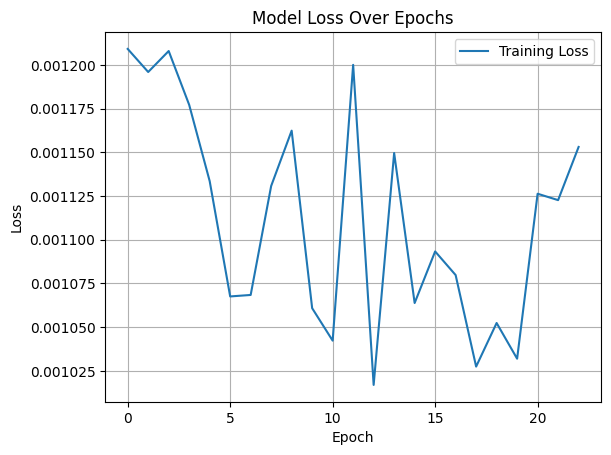

In [34]:
history = model.fit(X, y, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)

plt.plot(history.history['loss'], label='Training Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [26]:
# Predicting closing price for next day (July 12, 2025)
last_60_days = scaled_data[-60:]
last_60_days = np.reshape(last_60_days, (1, 60, 1))

predicted_price = model.predict(last_60_days)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Close Price for {ticker} on 2025-07-12: ${predicted_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Predicted Close Price for AAPL on 2025-07-12: $208.91


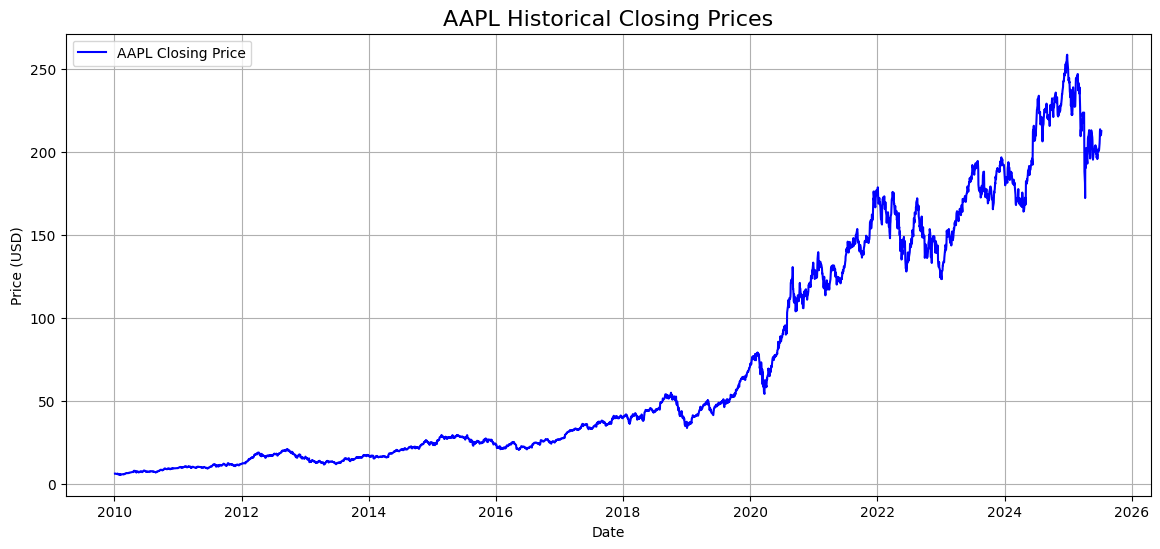

In [27]:
# Ploting historical 'Close' price
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label=f"{ticker} Closing Price", color='blue')
plt.title(f"{ticker} Historical Closing Prices", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


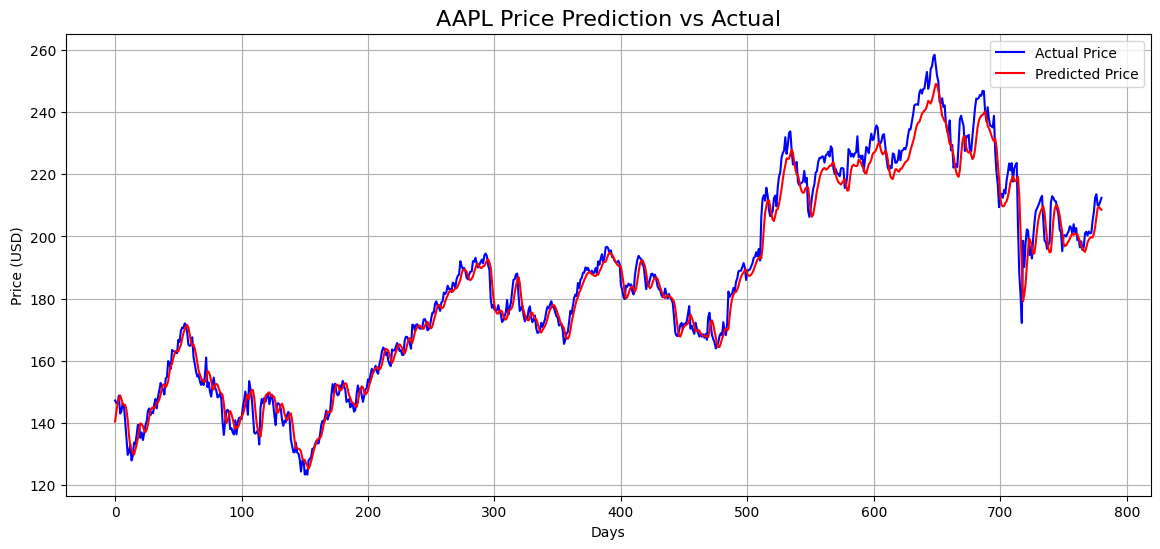

In [28]:
# Create training/testing split (80% train, 20% test)
training_data_len = int(len(scaled_data) * 0.8)

train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 60:]

X_test, y_test = [], []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform actual y_test
y_test_scaled = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

# Plot predictions vs actual
plt.figure(figsize=(14, 6))
plt.plot(y_test_scaled, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title(f"{ticker} Price Prediction vs Actual", fontsize=16)
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

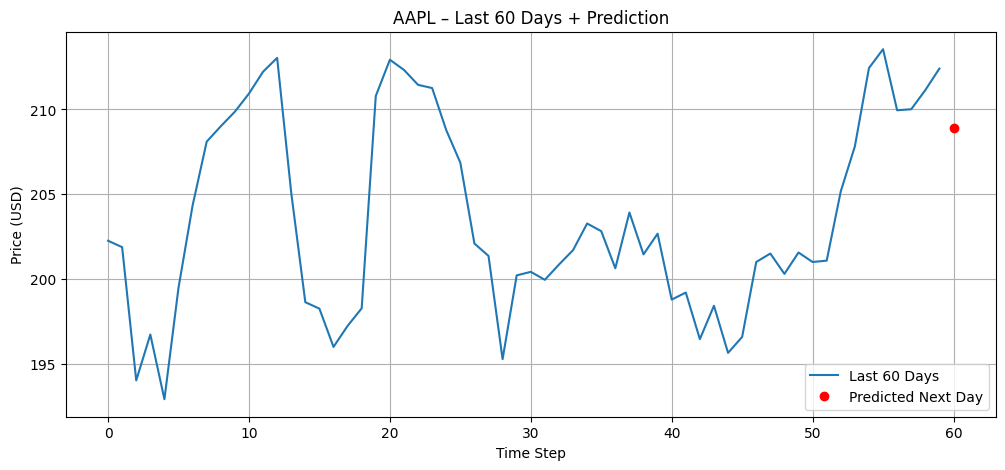

In [29]:
# Show the latest 60 days + predicted next day

last_60_days_scaled = scaler.inverse_transform(last_60_days.reshape(-1, 1))

future = np.append(last_60_days_scaled, predicted_price)

plt.figure(figsize=(12, 5))
plt.plot(range(60), last_60_days_scaled, label="Last 60 Days")
plt.plot(60, predicted_price[0][0], 'ro', label="Predicted Next Day")
plt.title(f"{ticker} – Last 60 Days + Prediction")
plt.xlabel("Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

**Last N-days**

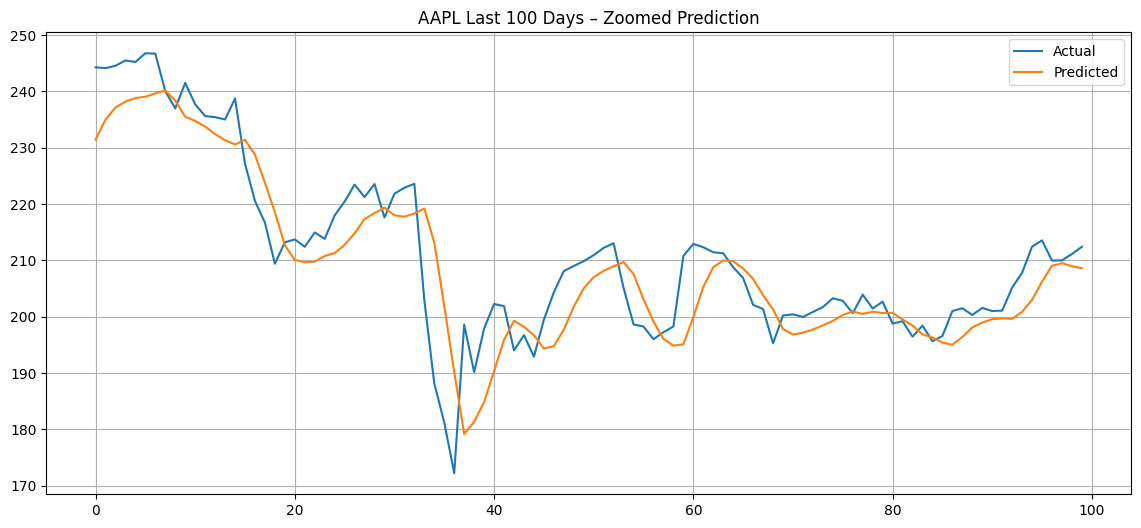

In [30]:
n = 100
plt.figure(figsize=(14, 6))
plt.plot(y_test_scaled[-n:], label='Actual')
plt.plot(predictions[-n:], label='Predicted')
plt.title(f"{ticker} Last {n} Days – Zoomed Prediction")
plt.legend()
plt.grid(True)
plt.show()

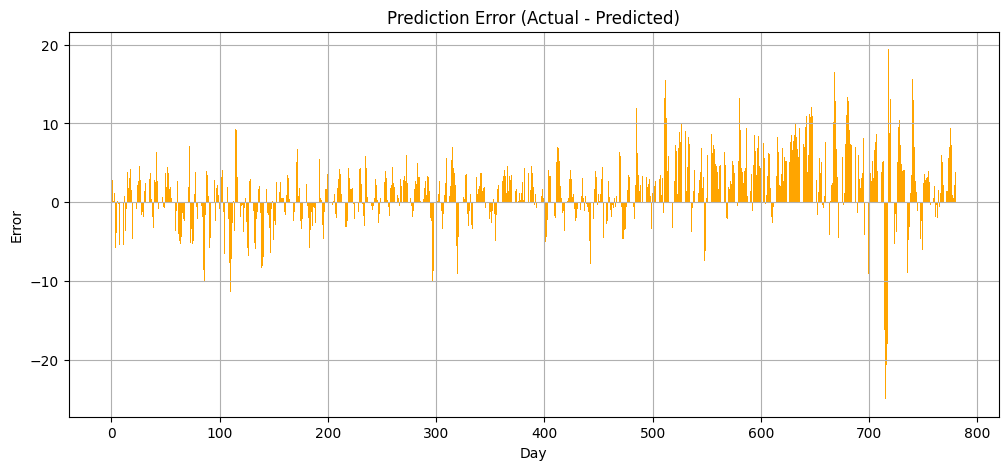

In [31]:
errors = y_test_scaled.flatten() - predictions.flatten()

plt.figure(figsize=(12, 5))
plt.bar(range(len(errors)), errors, color='orange')
plt.title("Prediction Error (Actual - Predicted)")
plt.xlabel("Day")
plt.ylabel("Error")
plt.grid(True)
plt.show()

In [33]:
import plotly.graph_objs as go

# Create X-axis labels from the test set (dates)
test_dates = df.index[-len(predictions):]

# Create the interactive figure
fig = go.Figure()

# Actual Price Trace
fig.add_trace(go.Scatter(
    x=test_dates,
    y=y_test_scaled.flatten(),
    mode='lines+markers',
    name='Actual',
    hovertemplate='Date: %{x}<br>Actual Price: %{y:.2f}<extra></extra>'
))

# Predicted Price Trace
fig.add_trace(go.Scatter(
    x=test_dates,
    y=predictions.flatten(),
    mode='lines+markers',
    name='Predicted',
    hovertemplate='Date: %{x}<br>Predicted Price: %{y:.2f}<extra></extra>'
))

# Customize layout
fig.update_layout(
    title=f"{ticker} Interactive Prediction",
    xaxis_title="Date",
    yaxis_title="Stock Price (USD)",
    hovermode="x unified",
    template="plotly_dark"  # Optional: dark theme
)

# Show the interactive plot
fig.show()

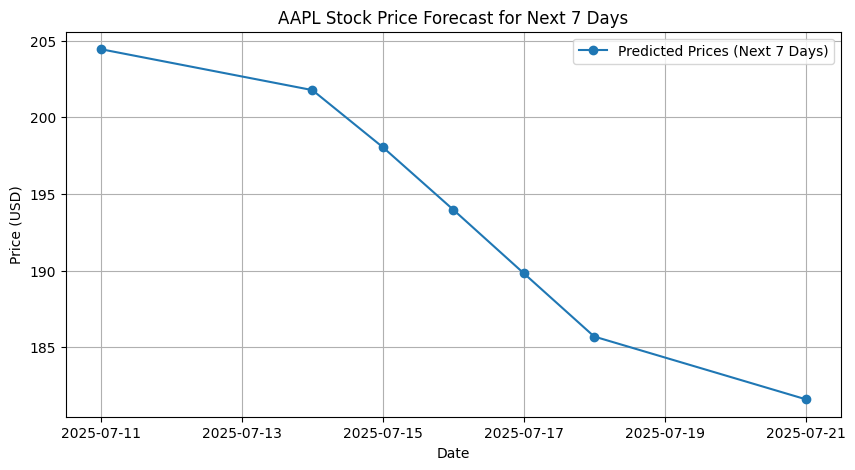

In [38]:
## Next 7 days

future_predictions = []

# Get the last 60 days of scaled prices
last_60_days = scaled_data[-60:]
input_sequence = last_60_days.copy()  # shape: (60, 1)

for day in range(7):

    input_reshaped = input_sequence.reshape(1, 60, 1)

    predicted_price = model.predict(input_reshaped, verbose=0)

    future_predictions.append(predicted_price[0][0])

    input_sequence = np.append(input_sequence, predicted_price)[1:]

future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

from datetime import timedelta

last_date = df.index[-1]

# Create next 7 business days (skip weekends)
future_dates = []
while len(future_dates) < 7:
    last_date += timedelta(days=1)
    if last_date.weekday() < 5:  # Monday=0, Sunday=6
        future_dates.append(last_date)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_prices, marker='o', label="Predicted Prices (Next 7 Days)")
plt.title(f"{ticker} Stock Price Forecast for Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()


# **Using GRU**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

gru = Sequential()

# First GRU layer
gru.add(GRU(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
gru.add(Dropout(0.3))

# Second GRU layer
gru.add(GRU(units=100, return_sequences=True))
gru.add(Dropout(0.3))

# Third GRU layer
gru.add(GRU(units=50, return_sequences=False))
gru.add(Dropout(0.3))

# Dense output layer
gru.add(Dense(units=1))

# Compile the gru
gru.compile(optimizer='adam', loss='mean_squared_error')

# gru summary
gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 60, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 60, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,351 (446.68 KB)

 Trainable params: 114,351 (446.68 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the GRU model
gru.fit(X, y, epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0207
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0024
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0016
Epoch 9/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0015
Epoch 10/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016
Epoch 11/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015
Epoch 12/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014
Epoch 13/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 14/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 15/100
121/121 ━━━━━━━━

In [19]:
# Predicting closing price for next day (July 12, 2025)
last_60_days = scaled_data[-60:]
last_60_days = np.reshape(last_60_days, (1, 60, 1))

predicted_price = gru.predict(last_60_days)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Close Price for {ticker} on 2025-07-12: ${predicted_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Close Price for AAPL on 2025-07-12: $198.03
